# Design of comparative analysis - illustrative example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context
import matplotlib.patheffects as pe
import scvelo as scv
import milopy

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_example/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()

design_palette = {'PAC':pal[3], 'PC':pal[7], 'PA':pal[9], 'joint_PC':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

dataset_palette = {'Atlas':pal[0], 'Control':pal[1], 'Disease':pal[4]}

In [9]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette)
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette)
}

In [10]:
short_pop_names = {"DC":'conventional_dendritic_cell', 
 "naive B":'naive_B_cell',
 "memory B":'memory_B_cell',                  
 "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell',
 'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
    'neutrophil':'neutrophil', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

plotting utils

In [11]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

### Simulation construction

In [13]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
h5ad_file = 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'
adata = sc.read_h5ad(outdir + h5ad_file, backed=True)

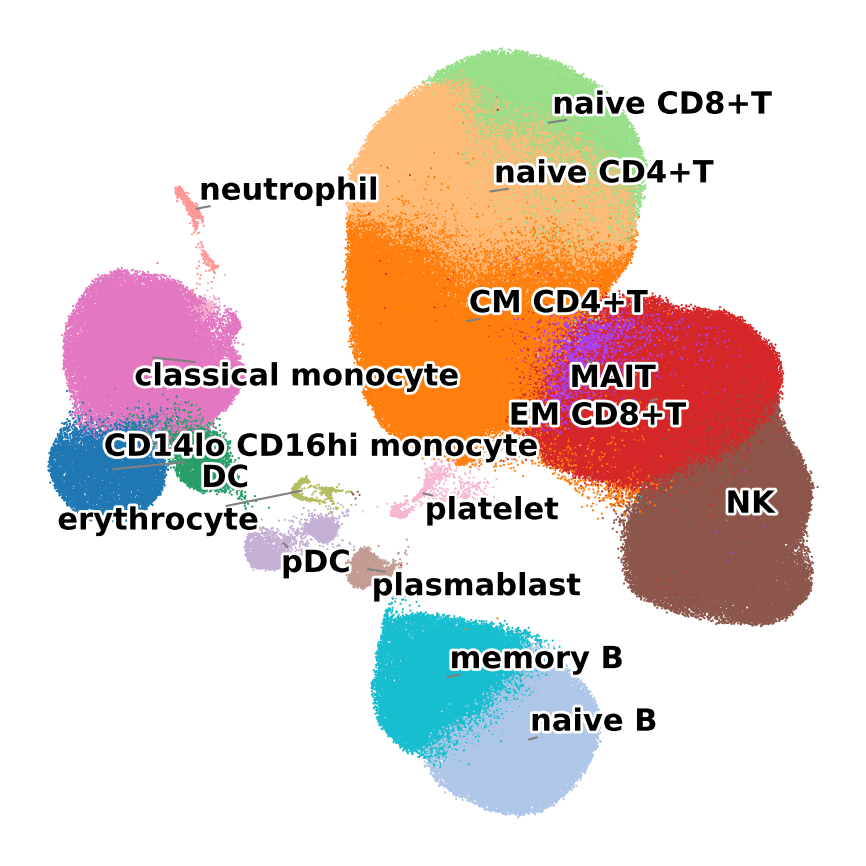

In [23]:
adata.obs['cell_type_short'] = [short_pop_names[x] for x in adata.obs['cell_type']]

with rc_context({'figure.figsize':[9,9]}):
    ax = sc.pl.umap(adata, color=['cell_type_short'], size=10, 
                frameon=False,
                title="", show=False, legend_loc=None)
    scatterplot = ax.collections[0]
    scatterplot.set_rasterized(True)
    np.random.seed(0)
    gen_mpl_labels(
        adata,
        "cell_type_short",
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='grey')),
        text_kwargs=dict(fontsize=22, fontweight='bold', color='black', path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.savefig(figdir + "integrated_dataset.pdf")

In [15]:
print(f"# studies: {adata.obs['dataset_id'].unique().shape[0]}")
print(f"# donors: {adata.obs['donor_id'].unique().shape[0]}")
print(f"# cells: {adata.n_obs}")


# studies: 13
# donors: 1248
# cells: 597321


In [50]:
## Pick simulation
perturb_pop = 'natural_killer_cell'
simdir = f"qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/"
disease_adata = sc.read_h5ad(outdir + simdir + 'query.h5ad', backed=True)
ctrl_adata = sc.read_h5ad(outdir + simdir + 'ctrl.h5ad', backed=True)
atlas_adata = sc.read_h5ad(outdir + simdir + 'atlas.h5ad', backed=True)

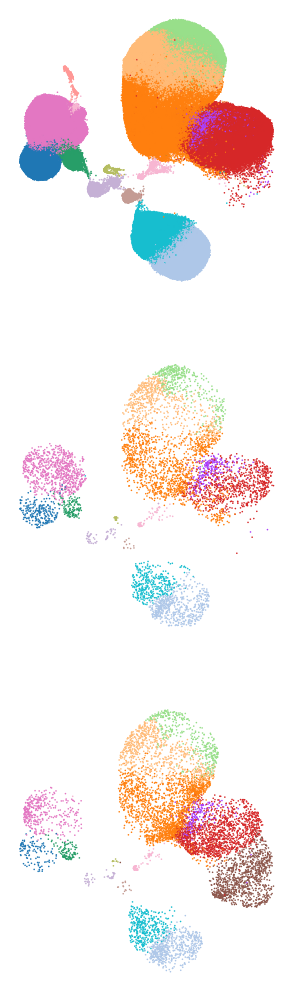

In [71]:
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(3,1)
    sc.pl.umap(adata[adata.obs_names.isin(atlas_adata.obs_names)], color='cell_type_short', size=10, 
                    frameon=False, legend_loc='none',
                    title="", show=False,ax = axs[0])
    sc.pl.umap(adata[adata.obs_names.isin(ctrl_adata.obs_names)], color='cell_type_short', size=10, 
                    frameon=False, legend_loc='none',
                    title="", show=False,ax = axs[1])
    sc.pl.umap(adata[adata.obs_names.isin(disease_adata.obs_names)], color='cell_type_short', size=10, 
                    frameon=False, legend_loc='none',
                    title="", show=False,ax = axs[2])
    plt.subplots_adjust( hspace=0.2 )
    fig.savefig(figdir + "simulated_split.png")

In [73]:
print("Atlas stats")
print("------------")
print(f"# studies: {atlas_adata.obs['dataset_id'].unique().shape[0]}")
print(f"# donors: {atlas_adata.obs['donor_id'].unique().shape[0]}")
print(f"# cells: {atlas_adata.n_obs}")

print("Ctrl stats")
print("------------")
print(f"# studies: {ctrl_adata.obs['dataset_id'].unique().shape[0]}")
print(f"# donors: {ctrl_adata.obs['donor_id'].unique().shape[0]}")
print(f"# cells: {ctrl_adata.n_obs}")

print("Disease stats")
print("------------")
print(f"# studies: {disease_adata.obs['dataset_id'].unique().shape[0]}")
print(f"# donors: {disease_adata.obs['donor_id'].unique().shape[0]}")
print(f"# cells: {disease_adata.n_obs}")

Atlas stats
------------
# studies: 12
# donors: 1219
# cells: 513565
Ctrl stats
------------
# studies: 1
# donors: 13
# cells: 5671
Disease stats
------------
# studies: 1
# donors: 16
# cells: 7505


## Training plots

In [12]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
perturb_pop = 'natural_killer_cell'
simdir = f"qPBMC_500cells_demo_perturb_cell_type{perturb_pop}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/"

In [15]:
acr_adata = sc.read_h5ad(outdir + simdir + 'ACR_design.scArches_milo.h5ad', backed=True)
ar_adata = sc.read_h5ad(outdir + simdir + 'ar_design.h5ad'  , backed=True)
cr_scarches_adata = sc.read_h5ad(outdir + simdir + 'CR_design.scArches_milo.h5ad'  , backed=True)
cr_scvi_adata = sc.read_h5ad(outdir + simdir + 'CR_design.scVI_milo.h5ad'  , backed=True)

In [20]:
X_umap_acr = pd.read_csv("/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/X_umap_PAC_example.csv", index_col=0)
X_umap_ar = pd.read_csv("/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/X_umap_PA_example.csv", index_col=0)
X_umap_cr_scarches = pd.read_csv("/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/X_umap_PC_example.csv", index_col=0)
# X_umap_cr_scvi = pd.read_csv("/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/X_umap_PC_example_scVI.csv", index_col=0)

In [21]:
acr_adata.obsm['X_umap'] = X_umap_acr.loc[acr_adata.obs_names].values
ar_adata.obsm['X_umap'] = X_umap_ar.loc[ar_adata.obs_names].values
cr_scarches_adata.obsm['X_umap'] = X_umap_cr_scarches.loc[cr_scarches_adata.obs_names].values
cr_scvi_adata.obsm['X_umap'] = X_umap_cr_scvi.loc[cr_scvi_adata.obs_names].values

In [22]:
# sc.tl.umap(acr_adata)
# sc.tl.umap(ac_adata)
# sc.tl.umap(cr_scarches_adata)
# sc.tl.umap(cr_scvi_adata)

In [23]:
dataset_dict = {'ctrl':'Control', 'query': "Disease", 'atlas':"Atlas"}
acr_adata.obs['dataset_group_clean'] = [dataset_dict[x] for x in acr_adata.obs['dataset_group']]
ar_adata.obs['dataset_group_clean'] = [dataset_dict[x] for x in ar_adata.obs['dataset_group']]
cr_scarches_adata.obs['dataset_group_clean'] = [dataset_dict[x] for x in cr_scarches_adata.obs['dataset_group']]
cr_scvi_adata.obs['dataset_group_clean'] = [dataset_dict[x] for x in cr_scvi_adata.obs['dataset_group']]

acr_adata.strings_to_categoricals()
ar_adata.strings_to_categoricals()
cr_scarches_adata.strings_to_categoricals()
cr_scvi_adata.strings_to_categoricals()

In [158]:
# def set_obs_palette(adata, obs, palette_dict):
#     adata.uns[obs + "_colors"] = [palette_dict[x] for x in adata.obs[obs].cat.categories]

# set_obs_palette(acr_adata, 'dataset_group_clean', dataset_palette)
# set_obs_palette(ar_adata, 'dataset_group_clean', dataset_palette)
# set_obs_palette(cr_adata, 'dataset_group_clean', dataset_palette)

<AxesSubplot:title={'center':'dataset_group_clean'}, xlabel='UMAP1', ylabel='UMAP2'>

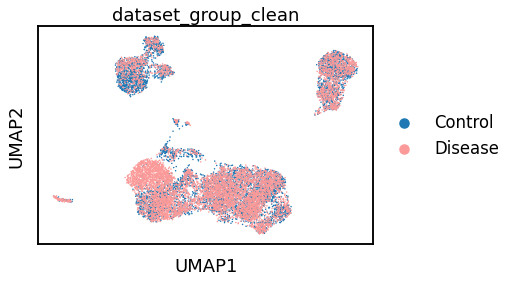

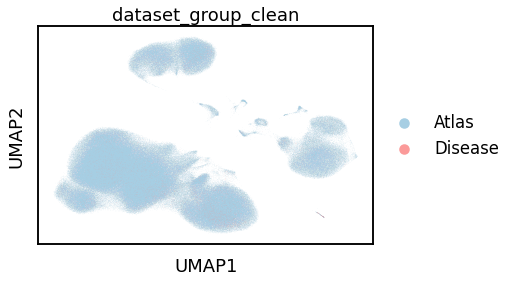

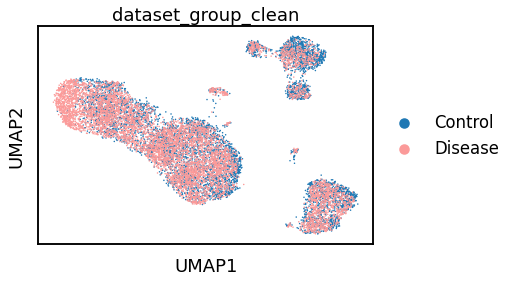

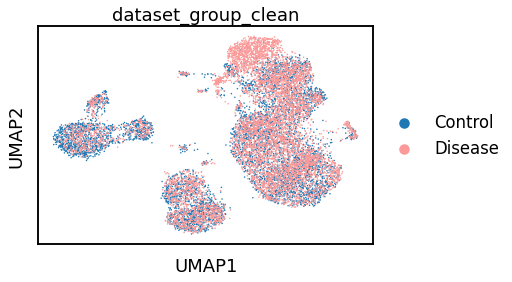

In [25]:
sc.pl.umap(acr_adata, color='dataset_group_clean', palette=dataset_palette, show=False)
sc.pl.umap(ar_adata, color='dataset_group_clean', palette=dataset_palette, show=False)
sc.pl.umap(cr_scarches_adata, color='dataset_group_clean', palette=dataset_palette, show=False)
sc.pl.umap(cr_scvi_adata, color='dataset_group_clean', palette=dataset_palette, show=False)

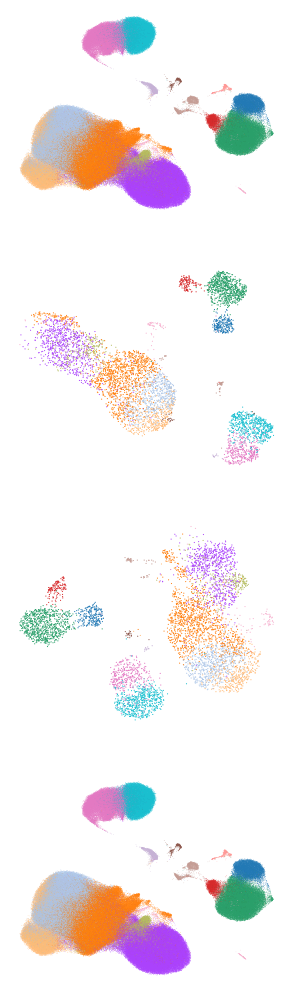

In [26]:
## Training
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(4,1)
    sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
               color='cell_type', size=1, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[0])
    sc.pl.umap(cr_scarches_adata[cr_scarches_adata.obs['dataset_group_clean'] == 'Control'], 
               color='cell_type', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[1])
    sc.pl.umap(cr_scvi_adata[cr_scvi_adata.obs['dataset_group_clean'] == 'Control'], 
               color='cell_type', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[2])
    sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
               color='cell_type', size=1, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[3])
    plt.subplots_adjust( hspace=0.2 )
    fig.savefig(figdir + "training2.png")

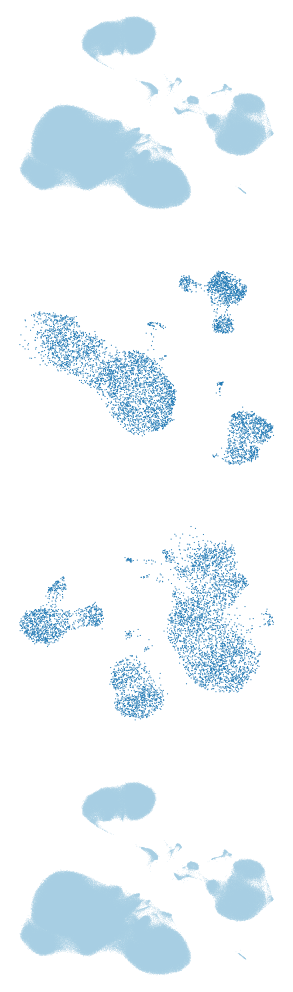

In [28]:
## Training
# with rc_context({'figure.figsize':[5,15]}):
#     fig,axs = plt.subplots(3,1)
#     sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
#                color='dataset_group_clean', size=1, 
#                 frameon=False, legend_loc='none',
#                 title="", show=False,ax = axs[0])
#     sc.pl.umap(cr_adata[cr_adata.obs['dataset_group_clean'] == 'Control'], 
#                color='dataset_group_clean', size=5, 
#                 frameon=False, legend_loc='none',
#                 title="", show=False,ax = axs[1])
#     sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
#                color='dataset_group_clean', size=1, 
#                 frameon=False, legend_loc='none',
#                 title="", show=False,ax = axs[2])
#     plt.subplots_adjust( hspace=0.2 )
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(4,1)
    sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
               color='dataset_group_clean', size=1, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[0])
    sc.pl.umap(cr_scarches_adata[cr_scarches_adata.obs['dataset_group_clean'] == 'Control'], 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[1])
    sc.pl.umap(cr_scvi_adata[cr_scvi_adata.obs['dataset_group_clean'] == 'Control'], 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[2])
    sc.pl.umap(ar_adata[ar_adata.obs['dataset_group_clean'] == 'Atlas'], 
               color='dataset_group_clean', size=1, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[3])
    plt.subplots_adjust( hspace=0.2 )
    fig.savefig(figdir + "training.png")

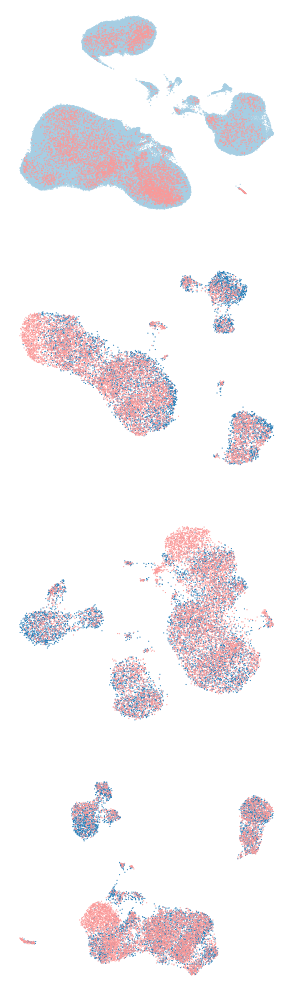

In [35]:
## Mapping
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(4,1)
    sc.pl.umap(ar_adata, 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[0])
    sc.pl.umap(cr_scarches_adata, 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[1])
    sc.pl.umap(cr_scvi_adata, 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[2])
    sc.pl.umap(acr_adata, 
               color='dataset_group_clean', size=5, 
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[3])
    plt.subplots_adjust( hspace=0.2 )
    fig.savefig(figdir + "mapping.png")

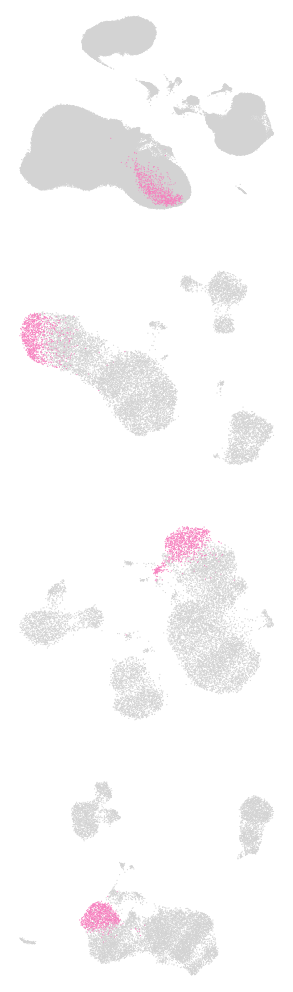

In [38]:
acr_adata.obs['OOR'] = np.where(acr_adata.obs['cell_type'] == perturb_pop, 'OOR', 'other')
cr_scarches_adata.obs['OOR'] = np.where(cr_scarches_adata.obs['cell_type'] == perturb_pop, 'OOR', 'other')
cr_scvi_adata.obs['OOR'] = np.where(cr_scvi_adata.obs['cell_type'] == perturb_pop, 'OOR', 'other')
ar_adata.obs['OOR'] = np.where(ar_adata.obs['cell_type'] == perturb_pop, 'OOR', 'other')

oor_palette = {"OOR":'#f781bf', 'other':'lightgrey'} 

## OOR population
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(4,1)
    sc.pl.umap(ar_adata, 
               color='OOR', size=5, palette=oor_palette,
                frameon=False, legend_loc='none',
                title="", show=False,ax = axs[0])
    sc.pl.umap(cr_scarches_adata, 
               color='OOR', size=5, 
                frameon=False, legend_loc='none',palette=oor_palette,
                title="", show=False,ax = axs[1])
    sc.pl.umap(cr_scvi_adata, 
               color='OOR', size=5, 
                frameon=False, legend_loc='none',palette=oor_palette,
                title="", show=False,ax = axs[2])
    sc.pl.umap(acr_adata, 
               color='OOR', size=5, 
                frameon=False, legend_loc='none',palette=oor_palette,

               title="", show=False,ax = axs[3])
    plt.subplots_adjust( hspace=0.2 )
    fig.savefig(figdir + "OOR.png")

### Differential analysis

In [39]:
## Save UMAP coords
X_umap_pac = acr_adata.obsm['X_umap'].copy()
X_umap_pa = ar_adata.obsm['X_umap'].copy()
X_umap_pc = cr_scarches_adata.obsm['X_umap'].copy()
X_umap_pc_scvi = cr_scvi_adata.obsm['X_umap'].copy()

X_umap_pac = pd.DataFrame(X_umap_pac, index = acr_adata.obs_names)
X_umap_pc = pd.DataFrame(X_umap_pc, index = cr_scarches_adata.obs_names)
X_umap_pc_scvi = pd.DataFrame(X_umap_pc_scvi, index = cr_scvi_adata.obs_names)
X_umap_pa = pd.DataFrame(X_umap_pa, index = ar_adata.obs_names)

In [40]:
acr_adata = milopy.utils.read_milo_adata(outdir + simdir + 'acr_design.h5ad', backed=True)
ar_adata = milopy.utils.read_milo_adata(outdir + simdir + 'ar_design.h5ad'  , backed=True)
cr_scarches_adata = milopy.utils.read_milo_adata(outdir + simdir + 'CR_design.scArches_milo.h5ad'  , backed=True)
cr_scvi_adata = milopy.utils.read_milo_adata(outdir + simdir + 'CR_design.scVI_milo.h5ad'  , backed=True)

In [41]:
acr_adata.obsm['X_umap'] = X_umap_pac.values.copy() 
cr_scarches_adata.obsm['X_umap'] = X_umap_pc.values.copy() 
cr_scvi_adata.obsm['X_umap'] = X_umap_pc_scvi.values.copy() 
ar_adata.obsm['X_umap'] = X_umap_pa.values.copy() 

In [42]:
milopy.utils.build_nhood_graph(acr_adata)
milopy.utils.build_nhood_graph(ar_adata)
milopy.utils.build_nhood_graph(cr_scarches_adata)
milopy.utils.build_nhood_graph(cr_scvi_adata)

In [43]:
def plot_nhood_graph(acr_adata, alpha=0.1, min_logFC=0, min_size=1, 
                     plot_edges=True, 
                     title='',
                     **kwargs):
    get_nhood_adata(acr_adata).obsm['X_umap'] = get_nhood_adata(acr_adata).obsm['X_milo_graph'].copy()
    
    get_nhood_adata(acr_adata).obs["graph_color"] = get_nhood_adata(acr_adata).obs["logFC"]
    get_nhood_adata(acr_adata).obs.loc[(get_nhood_adata(acr_adata).obs["SpatialFDR"]
                    > alpha) | (get_nhood_adata(acr_adata).obs['logFC'] < 0), "graph_color"] = 0
    get_nhood_adata(acr_adata).obs["abs_logFC"] = abs(get_nhood_adata(acr_adata).obs["logFC"])
    get_nhood_adata(acr_adata).obs.loc[get_nhood_adata(acr_adata).obs["abs_logFC"]
                    < min_logFC, "graph_color"] = np.nan
    # Plotting order - extreme logFC on top
    get_nhood_adata(acr_adata).obs.loc[get_nhood_adata(acr_adata).obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
    ordered = get_nhood_adata(acr_adata).obs.sort_values(
        'abs_logFC', na_position='first').index
#     get_nhood_adata(acr_adata) = get_nhood_adata(acr_adata)[ordered]
    
    vmax = np.max([get_nhood_adata(acr_adata).obs["graph_color"].max(),
                  abs(get_nhood_adata(acr_adata).obs["graph_color"].min())])
    vmin = - vmax
    
    scv.pl.umap(get_nhood_adata(acr_adata)[ordered], 
                    color="graph_color", cmap="RdBu_r",
                    size=acr_adata.uns["nhood_adata"].obs["Nhood_size"]*min_size,
                    sort_order=False,
                    frameon=False,
                    vmax=vmax, vmin=vmin,
                    title=title,
                    **kwargs
                    )

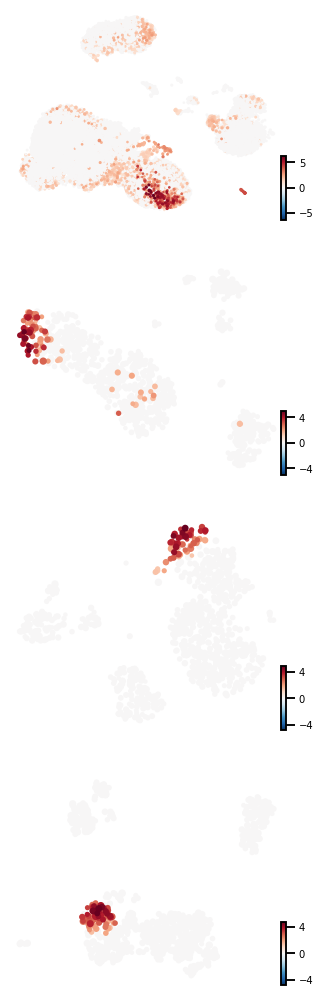

In [44]:
## OOR population
with rc_context({'figure.figsize':[5,18]}):
    fig,axs = plt.subplots(4,1)
    plot_nhood_graph(ar_adata, plot_edges=False, min_size=0.1, legend_loc= 'upper right',show=False, ax = axs[0])
    plot_nhood_graph(cr_scarches_adata, plot_edges=False, min_size=0.5, legend_loc= 'upper right', show=False, ax = axs[1])
    plot_nhood_graph(cr_scvi_adata, plot_edges=False, min_size=0.5, legend_loc= 'upper right', show=False, ax = axs[2])
    plot_nhood_graph(acr_adata, plot_edges=False, min_size=0.5, legend_loc= 'upper right',show=False,ax = axs[3])
    plt.subplots_adjust( hspace=0.2 );
    fig.savefig(figdir + "milo.png")

### Save embeddings for fast replotting

In [45]:
X_umap_pc_scvi.to_csv(outdir + 'X_umap_PC_scVI_example.csv')

In [224]:
X_umap_pac.to_csv(outdir + "X_umap_PAC_example.csv")
X_umap_pc.to_csv(outdir + "X_umap_PC_example.csv")
X_umap_pa.to_csv(outdir + "X_umap_PA_example.csv")